# Final Model for C3 Euclidian Resorting

In [1]:
model_name = 'EEGNet_5F'

## Initialize

### Pip install amd import functions

In [2]:
import pickle
import numpy as np
import h5py
# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from keras.utils import custom_object_scope


# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

2024-06-11 01:22:16.606133: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 01:22:16.623436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 01:22:16.623456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 01:22:16.623470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 01:22:16.627475: I tensorflow/core/platform/cpu_feature_g

In [3]:
def EEGNet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout', return_intermediate=False):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D or Dropout, passed as a string.')
    
    input1 = Input(shape=(Chans, Samples, 1))

    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)
    
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)
        
    flatten = Flatten(name='flatten')(block2)
    
    if return_intermediate:
        return Model(inputs=input1, outputs=flatten)
    
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [4]:
K.set_image_data_format('channels_last')

### Load data

In [5]:
import scipy.io

classes = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/classes.mat")['classes']
ERPs = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/ERPs.mat")['ERPs']

X = ERPs.copy()*1000 # format is in (trials, channels, samples)
y = classes.T[0].copy()
print(y)

[ 1  1  1 ... 12 12 12]


### Filter the data

In [6]:
import numpy as np
import scipy.signal as signal
import h5py
import time

def fir_filter(data, fs, lowcut, highcut, trans_width):
    nyquist = fs / 2
    numtaps = int(fs * 1)  # Reduce the length of the filter (1 second long)
    edges = [0, lowcut - trans_width, lowcut, highcut, highcut + trans_width, nyquist]
    taps = signal.firwin2(numtaps, edges, [0, 0, 1, 1, 0, 0], nyq=nyquist)
    filtered_data = signal.filtfilt(taps, 1.0, data)
    return filtered_data

def downsample(data, original_fs, target_fs):
    num_samples = int(len(data) * target_fs / original_fs)
    downsampled_data = signal.resample(data, num_samples)
    return downsampled_data

def process_batches(X, batch_size, output_path, lowcut, highcut, target_fs):
    num_channels = 22
    original_fs = 250
    
    num_trials, num_channels, num_samples = X.shape
    num_downsampled_samples = int(num_samples * target_fs / original_fs)

    with h5py.File(output_path, 'w') as f:
        all_filtered = f.create_dataset('filtered', (num_trials, num_channels, num_downsampled_samples), dtype='float32')

        for start in range(0, num_trials, batch_size):
            end = min(start + batch_size, num_trials)
            batch_start_time = time.time()  # Start timing the batch processing
            for channel in range(num_channels):
                print(f"\rProcessing trials {end}/{num_trials}\t- chans = {channel+1}/{num_channels}\t - ", end="")
                eeg_signal = X[start:end, channel, :]

                # Apply FIR filter
                filtered_signal = np.apply_along_axis(fir_filter, 1, eeg_signal, original_fs, lowcut, highcut, 2)
                
                # Downsample the signal
                downsampled_signal = np.apply_along_axis(downsample, 1, filtered_signal, original_fs, target_fs)
                
                all_filtered[start:end, channel, :] = downsampled_signal

            batch_end_time = time.time()  # End timing the batch processing
            batch_duration = batch_end_time - batch_start_time
            print(f"Batch processing time: {batch_duration:.2f} seconds")
        print(f"\n", end="")
    return output_path

#### Filter echo

In [8]:
batch_size = 500

output_path = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter1.h5'
process_batches(X, batch_size, output_path, 4, 8, 20)

output_path = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter2.h5'
process_batches(X, batch_size, output_path, 8, 12, 28)

output_path = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter3.h5'
process_batches(X, batch_size, output_path, 12, 22, 44)

output_path = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter4.h5'
process_batches(X, batch_size, output_path, 22, 32, 68)

output_path = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter5.h5'
process_batches(X, batch_size, output_path, 32, 64, 132)

Processing trials 500/7548	- chans = 22/22	 - Batch processing time: 124.18 seconds
Processing trials 1000/7548	- chans = 22/22	 - Batch processing time: 125.33 seconds
Processing trials 1500/7548	- chans = 22/22	 - Batch processing time: 129.65 seconds
Processing trials 2000/7548	- chans = 22/22	 - Batch processing time: 119.58 seconds
Processing trials 2500/7548	- chans = 22/22	 - Batch processing time: 117.78 seconds
Processing trials 3000/7548	- chans = 22/22	 - Batch processing time: 117.84 seconds
Processing trials 3500/7548	- chans = 22/22	 - Batch processing time: 115.06 seconds
Processing trials 4000/7548	- chans = 22/22	 - Batch processing time: 122.14 seconds
Processing trials 4500/7548	- chans = 22/22	 - Batch processing time: 143.59 seconds
Processing trials 5000/7548	- chans = 22/22	 - Batch processing time: 123.61 seconds
Processing trials 5500/7548	- chans = 22/22	 - Batch processing time: 123.95 seconds
Processing trials 6000/7548	- chans = 22/22	 - Batch processing ti

'/mnt/d/sharegit/MasterThesis_data/EEGNET5f/Filter5.h5'

### Prepare the data

In [8]:
import h5py
import numpy as np

# Function to load data from HDF5 file
def load_filtered_data(filepath):
    with h5py.File(filepath, 'r') as f:
        data = f['filtered'][:]
    return data

# Load each filtered dataset
filter1_data = load_filtered_data('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter1.h5')
filter2_data = load_filtered_data('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter2.h5')
filter3_data = load_filtered_data('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter3.h5')
filter4_data = load_filtered_data('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter4.h5')
filter5_data = load_filtered_data('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/Filter5.h5')

# Assuming data is in the shape (batch_size, samples, channels)
# Ensure all data arrays have the same shape except for the samples dimension
print(filter1_data.shape)
print(filter2_data.shape)
print(filter3_data.shape)
print(filter4_data.shape)
print(filter5_data.shape)

X = np.concatenate([filter1_data, filter2_data, filter3_data, filter4_data, filter5_data], axis=2)
print("Concatenated data shape:", X.shape)

(7548, 22, 100)
(7548, 22, 140)
(7548, 22, 220)
(7548, 22, 340)
(7548, 22, 660)
Concatenated data shape: (7548, 22, 1460)


In [9]:
# Use a smaller subset for testing (comment this out once the issue is resolved)
print(f'X shape: {X.shape}, X dtype: {X.dtype}')
print(f'y shape: {y.shape}, y dtype: {y.dtype}')

X shape: (7548, 22, 1460), X dtype: float32
y shape: (7548,), y dtype: uint8


In [10]:
from sklearn.model_selection import train_test_split

mod = [1,1,1,1,2,2,2,2,3,3,3,3]
for i, replacement in enumerate(mod, start=1):
    y[classes.T[0] == i] = replacement


# Split the data into 50% training and 50% temp (which will later be split into test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)

# Split the temp data into 50% test and 50% validation, resulting in 25% of the original data each
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(y_train)
num_classess = len(set(y_train))
print(f'There are {num_classess} unique classes in the dataset')

[1 2 2 ... 3 1 3]
There are 3 unique classes in the dataset


In [11]:
from collections import Counter

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# Count the occurrences of each class
counts = Counter(y)

# Calculate the total number of samples
total_samples = sum(counts.values())

# Number of classes
num_classes = len(counts)

# Calculate class weights
class_weights = {class_label-1: total_samples / (num_classes * count) for class_label, count in counts.items()}
#class_weights = {0:1, 1:1, 2:1}
print(class_weights)

{0: 1.1282511210762332, 1: 0.9469326307866014, 2: 0.9455092070650132}


In [12]:
kernels, chans, samples = 1, 22, 1460


# convert labels to one-hot encodings.
y_train      = np_utils.to_categorical(y_train-1)
y_val   = np_utils.to_categorical(y_val-1)
y_test       = np_utils.to_categorical(y_test-1)
print(y_train)
# convert data to NHWC (trials, channels, samples, kernels) format. Data
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_val   = X_val.reshape(X_val.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
X_train shape: (3774, 22, 1460, 1)
3774 train samples
1887 test samples


## Implement EEGNET without Hyperparameters

### Compile model

In [18]:
num_classess =3
chans = 22
models = []

models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 100,
               dropoutRate = 0.5, kernLength = 6, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 140,
               dropoutRate = 0.5, kernLength = 10, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 220,
               dropoutRate = 0.5, kernLength = 18, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 340,
               dropoutRate = 0.5, kernLength = 26, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 660,
               dropoutRate = 0.5, kernLength = 48, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))

# compile the model and set the optimizers
for model in models:
    model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
    print(model.count_params())

models[0].summary()

1219
1299
1459
1715
2371
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 100, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 22, 100, 8)        48        
                                                                 
 batch_normalization (Batch  (None, 22, 100, 8)        32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 100, 16)        352       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 100, 16)        64        
 chNormalization)                                                
                                    

### Train model

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint


lims = [0,100,240,460,800,1460]

for mod in range(5):
    # set a valid path for your system to record model checkpoints
    checkpoint_path= '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod'+str(mod) +'.h5'
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
    X_t = X_train[:,:,lims[mod]:lims[mod+1],:]
    X_v = X_val[:,:,lims[mod]:lims[mod+1],:]
    # load optimal weights
    #model.load_weights('checkpoint_ACC65p_3class.keras', by_name=True, skip_mismatch=True)
    fittedModel = models[mod].fit(X_t, y_train, batch_size = 16, epochs = 1000,
                            verbose = 2, validation_data=(X_v, y_val),
                            callbacks=checkpointer, class_weight = class_weights)

    filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod'+str(mod) +'.pkl'
    
    # Open the file in write-binary mode and dump the variables
    with open(filepath, 'wb') as f:
        pickle.dump({'fittedModel': fittedModel, 'model': models[mod]}, f)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 1.05097, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNet_5F/checkpointmod0.h5
236/236 - 2s - loss: 1.0298 - accuracy: 0.4658 - val_loss: 1.0510 - val_accuracy: 0.4335 - 2s/epoch - 8ms/step
Epoch 2/1000

Epoch 2: val_loss did not improve from 1.05097
236/236 - 2s - loss: 1.0325 - accuracy: 0.4544 - val_loss: 1.0535 - val_accuracy: 0.4383 - 2s/epoch - 7ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.05097 to 1.04985, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNet_5F/checkpointmod0.h5
236/236 - 2s - loss: 1.0336 - accuracy: 0.4576 - val_loss: 1.0498 - val_accuracy: 0.4340 - 2s/epoch - 8ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 1.04985
236/236 - 2s - loss: 1.0305 - accuracy: 0.4557 - val_loss: 1.0525 - val_accuracy: 0.4282 - 2s/epoch - 7ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 1.04985 to 1.04983, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNet_5F/checkpointmod0.h5
236/23

### Assessment

#### Accuracy evaluation both methods

(1887, 22, 100, 1)
(1887, 22, 140, 1)
(1887, 22, 220, 1)
(1887, 22, 340, 1)
(1887, 22, 660, 1)
59/59 [==============================] - 0s 4ms/step
Ensemble Classification Accuracy: 0.6624271330153683


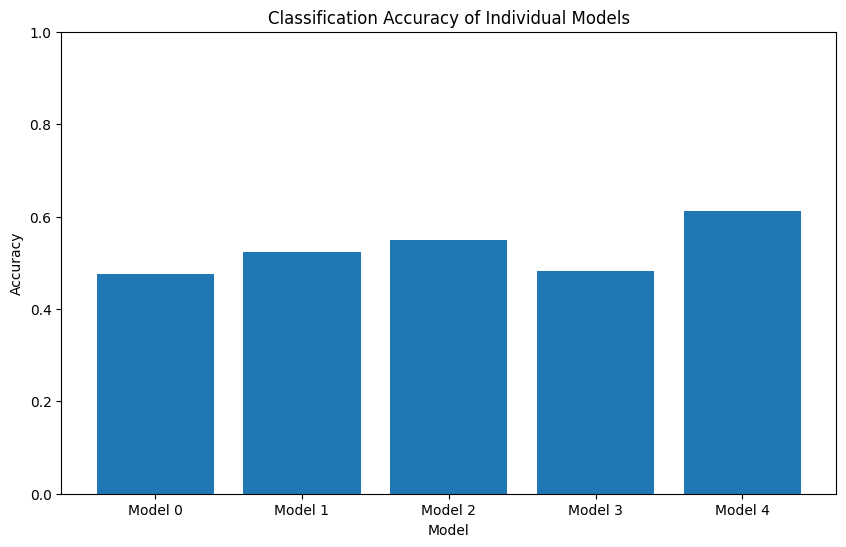

In [66]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Define file paths for models and weights
model_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod0.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod1.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod2.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod3.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod4.pkl'
]

weights_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod0.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod1.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod2.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod3.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod4.h5'
]

lims = [0,100,240,460,800,1460]
X_tsts = []

for mod in range(5):
    X_tsts.append(X_test[:,:,lims[mod]:lims[mod+1],:])
    print(np.shape(X_test[:,:,lims[mod]:lims[mod+1],:]))
    
# Assuming the models are recompiled and stored in a list named 'models'
# Load models and make predictions
ensemble_probs = np.zeros((X_test.shape[0], 3))  # Assuming 3 classes

for model, weights_path, X_tst in zip(models, weights_paths, X_tsts):
    model.load_weights(weights_path)
    probs = model.predict(X_tst)
    ensemble_probs += probs

# Average the probabilities
ensemble_probs /= len(models)

# Get final predictions
ensemble_preds = ensemble_probs.argmax(axis=-1)
ensemble_acc = np.mean(ensemble_preds == y_test.argmax(axis=-1))
print(f"Ensemble Classification Accuracy: {ensemble_acc}")

# Plot the accuracies of individual models
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracies)), accuracies, tick_label=[f'Model {i}' for i in range(len(accuracies))])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy of Individual Models')
plt.ylim(0, 1)
plt.show()


#### Performance

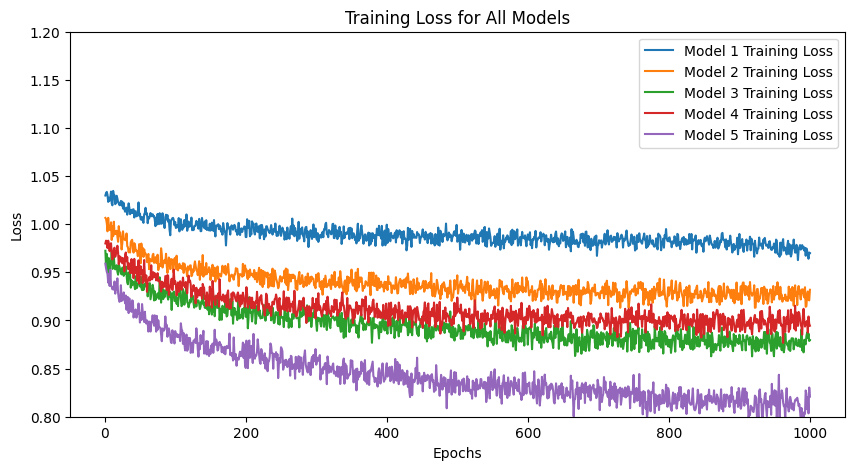

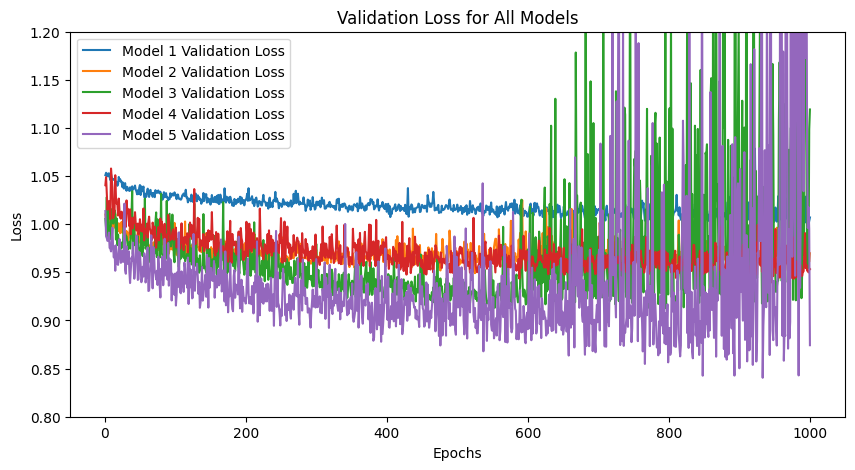

In [74]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Define file paths for models and weights
model_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod0.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod1.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod2.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod3.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod4.pkl'
]


# Lists to hold the training and validation losses
all_losses = []
all_val_losses = []

# Load training history from pickle files
for model_path in model_paths:
    with open(model_path, 'rb') as f:
        data = pickle.load(f)
    fittedModel = data['fittedModel']
    
    loss = fittedModel.history['loss']
    val_loss = fittedModel.history['val_loss']
    
    all_losses.append(loss)
    all_val_losses.append(val_loss)

# Combine all loss values to determine y_min and y_max
combined_losses = sum(all_losses + all_val_losses, [])
y_min = 0.8
y_max = 1.2  # Adjusted to provide a bit of margin

# Plot the training loss for all models in a single plot
plt.figure(figsize=(10, 5))
for i, loss in enumerate(all_losses):
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Model {i+1} Training Loss')
plt.title('Training Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plot the validation loss for all models in a single plot
plt.figure(figsize=(10, 5))
for i, val_loss in enumerate(all_val_losses):
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, label=f'Model {i+1} Validation Loss')
plt.title('Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

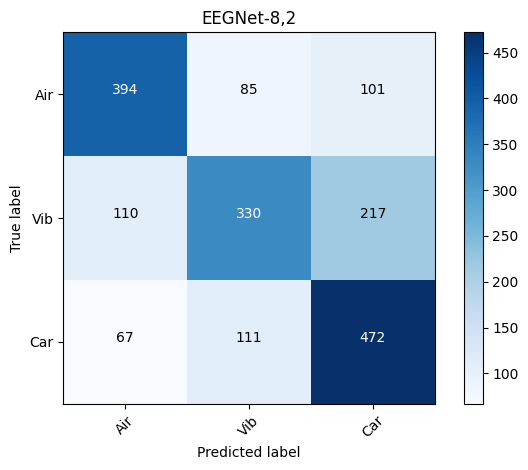

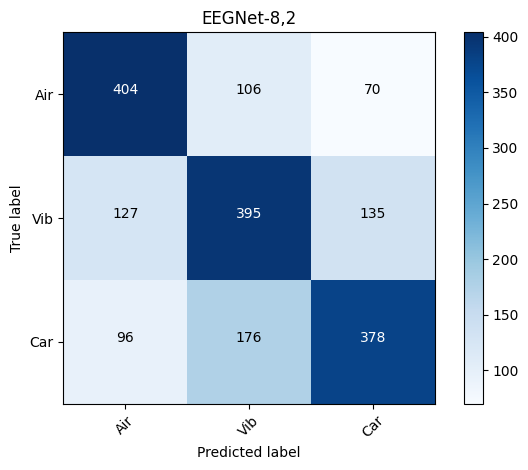

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization
import itertools  # Import itertools for product function

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds_hp)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

(1887, 22, 100, 1)
(1887, 22, 140, 1)
(1887, 22, 220, 1)
(1887, 22, 340, 1)
(1887, 22, 660, 1)
59/59 [==============================] - 0s 1ms/step
Ensemble Classification Accuracy: 0.6624271330153683


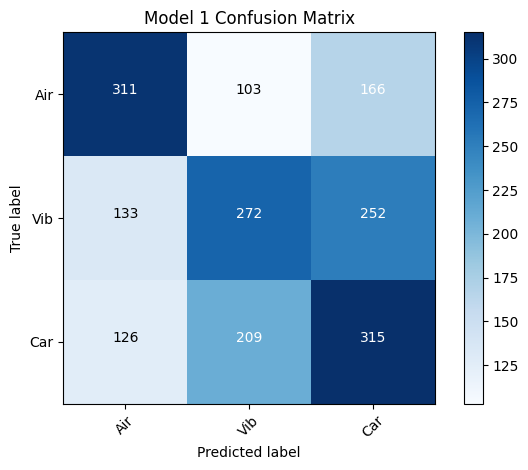

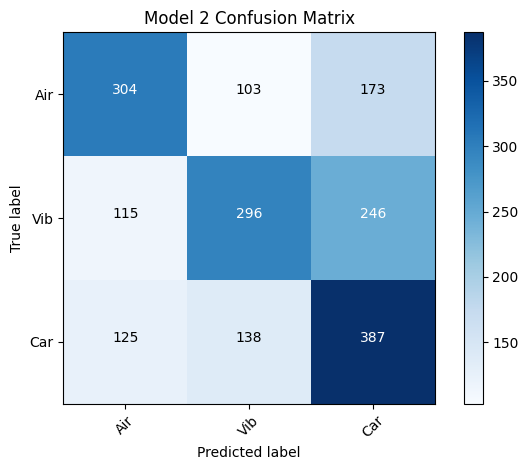

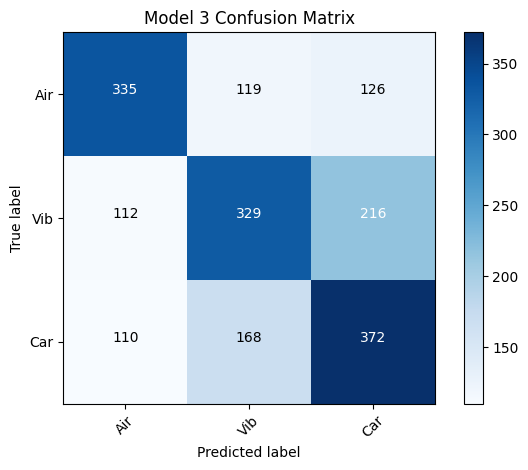

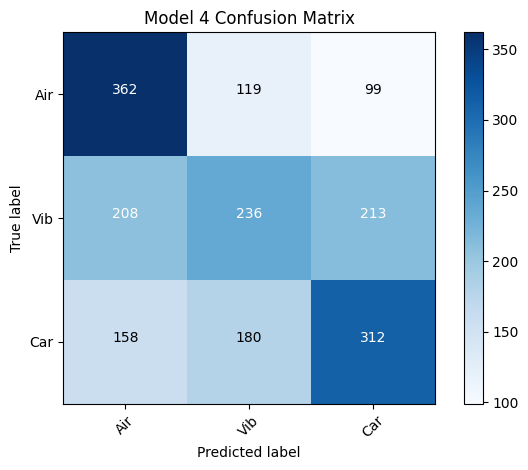

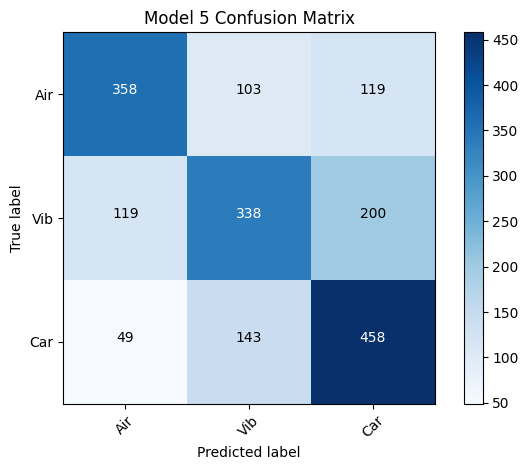

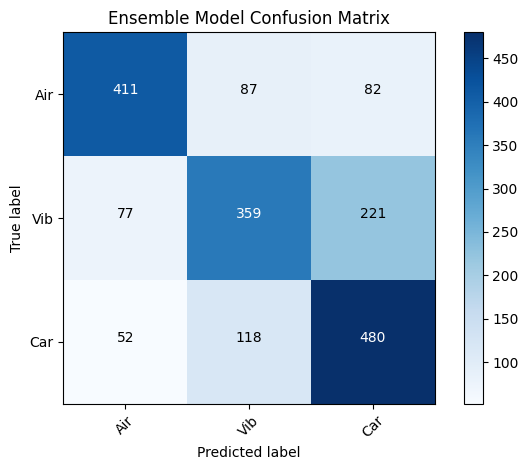

In [76]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization
import itertools  # Import itertools for product function

# Define file paths for models and weights
model_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod0.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod1.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod2.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod3.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod4.pkl'
]

weights_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod0.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod1.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod2.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod3.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod4.h5'
]

lims = [0, 100, 240, 460, 800, 1460]
X_tsts = []

for mod in range(5):
    X_tsts.append(X_test[:, :, lims[mod]:lims[mod+1], :])
    print(np.shape(X_test[:, :, lims[mod]:lims[mod+1], :]))

# Assuming the models are recompiled and stored in a list named 'models'
# Load models and make predictions
ensemble_probs = np.zeros((X_test.shape[0], 3))  # Assuming 3 classes
all_preds = []

for model, weights_path, X_tst in zip(models, weights_paths, X_tsts):
    model.load_weights(weights_path)
    probs = model.predict(X_tst)
    preds = probs.argmax(axis=-1)
    all_preds.append(preds)
    ensemble_probs += probs

# Average the probabilities
ensemble_probs /= len(models)

# Get final predictions
ensemble_preds = ensemble_probs.argmax(axis=-1)
ensemble_acc = np.mean(ensemble_preds == y_test.argmax(axis=-1))
print(f"Ensemble Classification Accuracy: {ensemble_acc}")

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrices for individual models
names = ['Air', 'Vib', 'Car']

for i, preds in enumerate(all_preds):
    cm = confusion_matrix(y_test.argmax(axis=-1), preds)
    plt.figure()
    plot_confusion_matrix(cm, names, f'Model {i+1} Confusion Matrix')
    plt.show()

# Compute confusion matrix for ensemble model
ensemble_cm = confusion_matrix(y_test.argmax(axis=-1), ensemble_preds)
plt.figure()
plot_confusion_matrix(ensemble_cm, names, 'Ensemble Model Confusion Matrix')
plt.show()

(1887, 22, 100, 1)
(1887, 22, 140, 1)
(1887, 22, 220, 1)
(1887, 22, 340, 1)
(1887, 22, 660, 1)
59/59 [==============================] - 0s 2ms/step
Ensemble Classification Accuracy: 0.6624271330153683


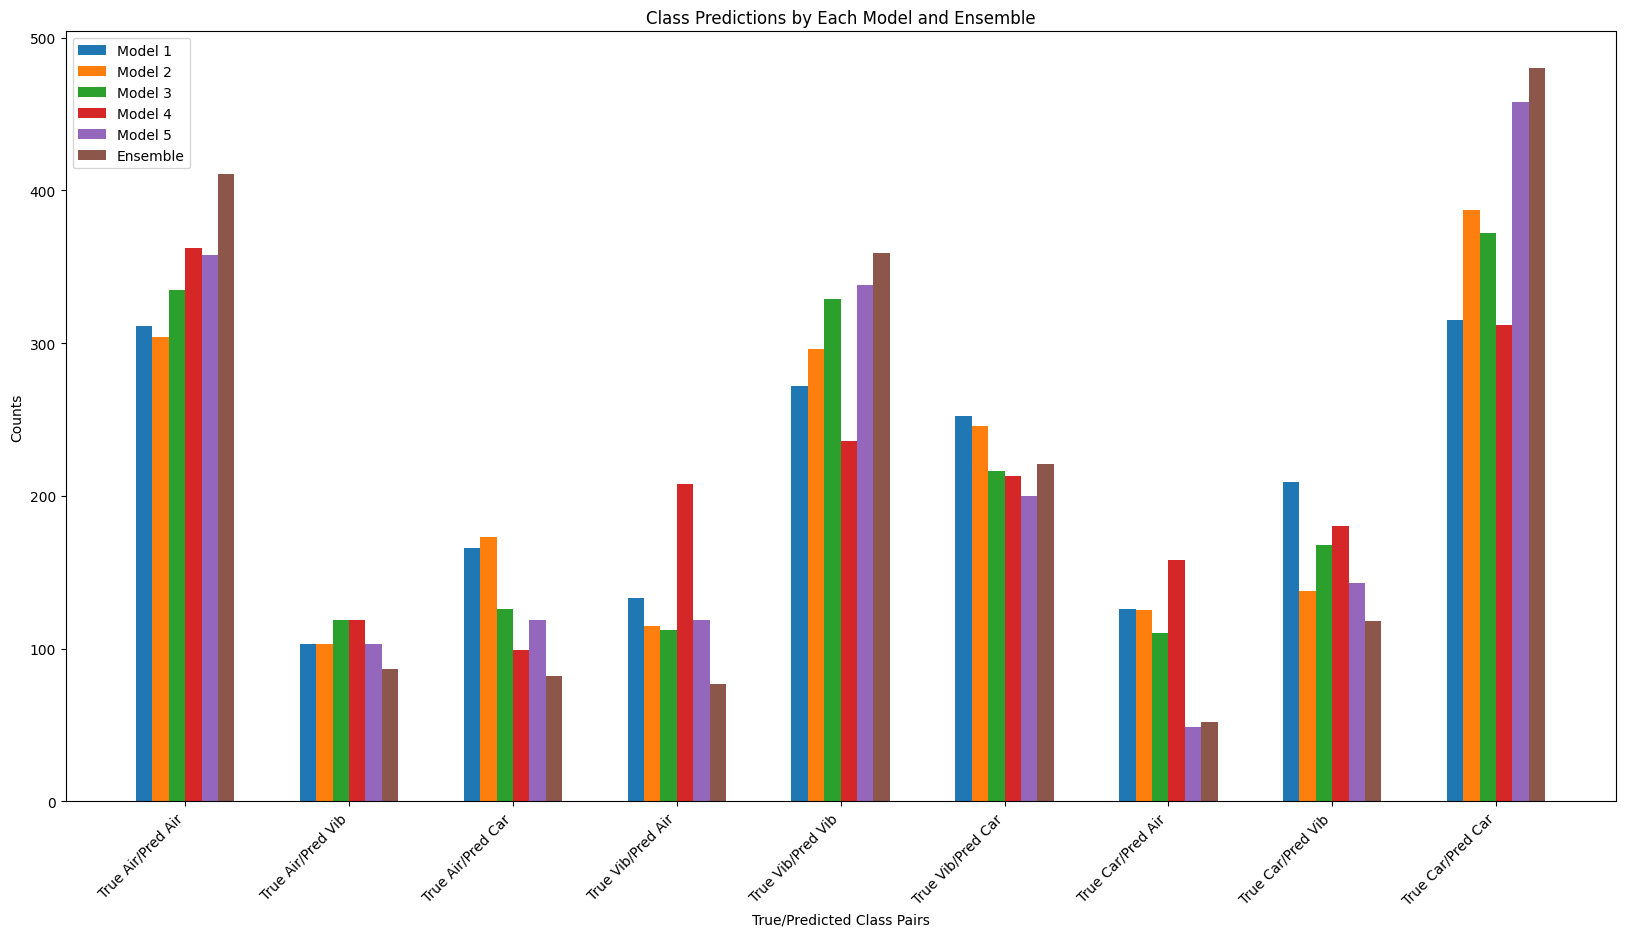

In [77]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Define file paths for models and weights
model_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod0.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod1.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod2.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod3.pkl',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmod4.pkl'
]

weights_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod0.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod1.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod2.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod3.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod4.h5'
]
lims = [0, 100, 240, 460, 800, 1460]
X_tsts = []

for mod in range(5):
    X_tsts.append(X_test[:, :, lims[mod]:lims[mod+1], :])
    print(np.shape(X_test[:, :, lims[mod]:lims[mod+1], :]))

# Assuming the models are recompiled and stored in a list named 'models'
# Load models and make predictions
ensemble_probs = np.zeros((X_test.shape[0], 3))  # Assuming 3 classes
all_preds = []

for model, weights_path, X_tst in zip(models, weights_paths, X_tsts):
    model.load_weights(weights_path)
    probs = model.predict(X_tst)
    preds = probs.argmax(axis=-1)
    all_preds.append(preds)
    ensemble_probs += probs

# Average the probabilities
ensemble_probs /= len(models)

# Get final predictions
ensemble_preds = ensemble_probs.argmax(axis=-1)
ensemble_acc = np.mean(ensemble_preds == y_test.argmax(axis=-1))
print(f"Ensemble Classification Accuracy: {ensemble_acc}")

# Compute confusion matrices for individual models
names = ['Air', 'Vib', 'Car']
all_cms = []

for preds in all_preds:
    cm = confusion_matrix(y_test.argmax(axis=-1), preds)
    all_cms.append(cm)

# Compute confusion matrix for ensemble model
ensemble_cm = confusion_matrix(y_test.argmax(axis=-1), ensemble_preds)
all_cms.append(ensemble_cm)

# Prepare data for bar chart
n_classes = len(names)
n_models = len(models) + 1  # Including the ensemble
bar_width = 0.1
index = np.arange(n_classes * n_classes)

# Initialize plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot bars for each model and the ensemble
for i, cm in enumerate(all_cms):
    counts = cm.flatten()
    bar_positions = index + (i * bar_width)
    ax.bar(bar_positions, counts, bar_width, label=f'Model {i+1}' if i < len(models) else 'Ensemble')

# Add labels and title
ax.set_xlabel('True/Predicted Class Pairs')
ax.set_ylabel('Counts')
ax.set_title('Class Predictions by Each Model and Ensemble')
ax.set_xticks(index + bar_width * (n_models - 1) / 2)
ax.set_xticklabels([f'True {t}/Pred {p}' for t in names for p in names], rotation=45, ha='right')
ax.legend()

plt.show()


#### Deep explainability

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from deepexplain.tensorflow import DeepExplain
from tensorflow.keras import backend as K
import numpy as np


num_classess =3
chans = 22
models = []

models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 100,
               dropoutRate = 0.5, kernLength = 6, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 140,
               dropoutRate = 0.5, kernLength = 10, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 220,
               dropoutRate = 0.5, kernLength = 18, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 340,
               dropoutRate = 0.5, kernLength = 26, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 660,
               dropoutRate = 0.5, kernLength = 48, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))

# compile the model and set the optimizers
for model in models:
    model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
    print(model.count_params())

weights_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod0.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod1.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod2.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod3.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod4.h5'
]

# Using DeepExplain to get feature relevances for individual models
for i, model in enumerate(models):
    K.clear_session()  # Clear the previous session
    tf.compat.v1.reset_default_graph()  # Reset the graph

    graph = tf.Graph()
    with graph.as_default():
        with tf.compat.v1.Session(graph=graph) as sess:
            tf.compat.v1.keras.backend.set_session(sess)

            with DeepExplain(session=sess) as de:
                input_tensor = model.layers[0].input
                fModel = Model(inputs=input_tensor, outputs=model.layers[-2].output)  # Dense layer before softmax
                target_tensor = fModel(input_tensor)

                # Explain using DeepLIFT
                attributions = de.explain('deeplift', target_tensor * y_test, input_tensor, X_test[:, :, lims[i]:lims[i+1], :])
                
                # Alternatively, you can use epsilon-LRP
                # attributions = de.explain('elrp', target_tensor * y_test, input_tensor, X_test[:, :, lims[i]:lims[i+1], :])

                print(f"Attributions for Model {i+1}:")
                print(attributions)

1219
1299
1459
1715
2371


2024-06-11 00:55:28.218403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 00:55:28.218509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 00:55:28.218540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 00:55:28.218748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 00:55:28.218775: I tensorflow/core/co

ValueError: Tensor("batch_normalization/gamma:0", shape=(), dtype=resource) must be from the same graph as Tensor("keras_learning_phase:0", shape=(), dtype=bool) (graphs are <tensorflow.python.framework.ops.Graph object at 0x7f8a1c15bbe0> and <tensorflow.python.framework.ops.Graph object at 0x7f896c5f48b0>).

1219
1299
1459
1715
2371


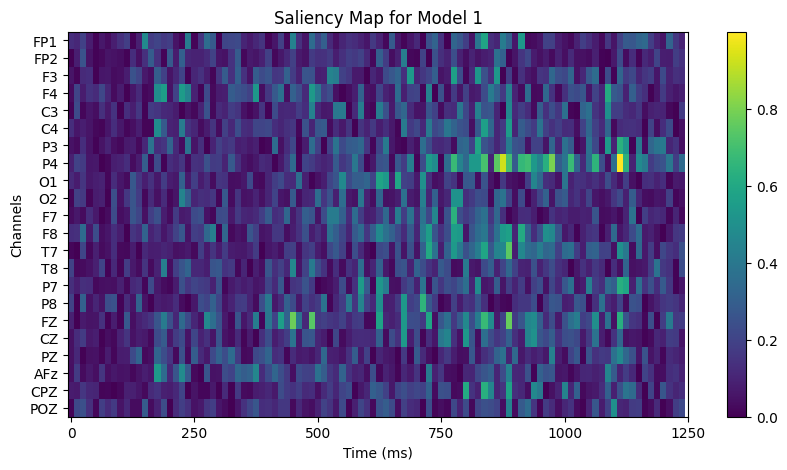

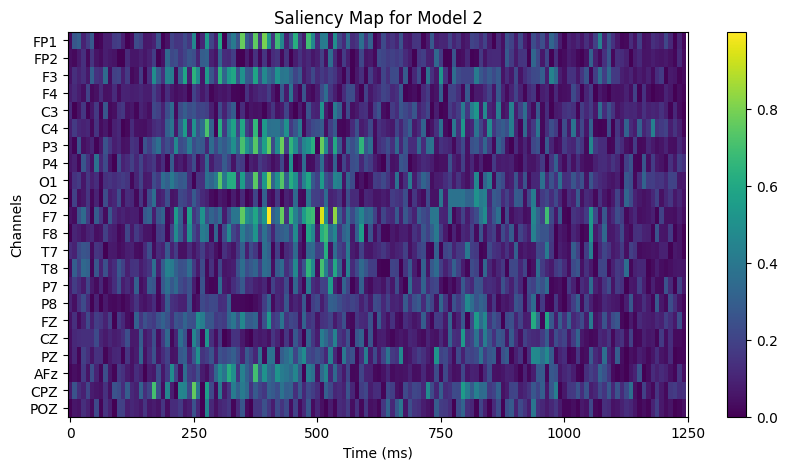

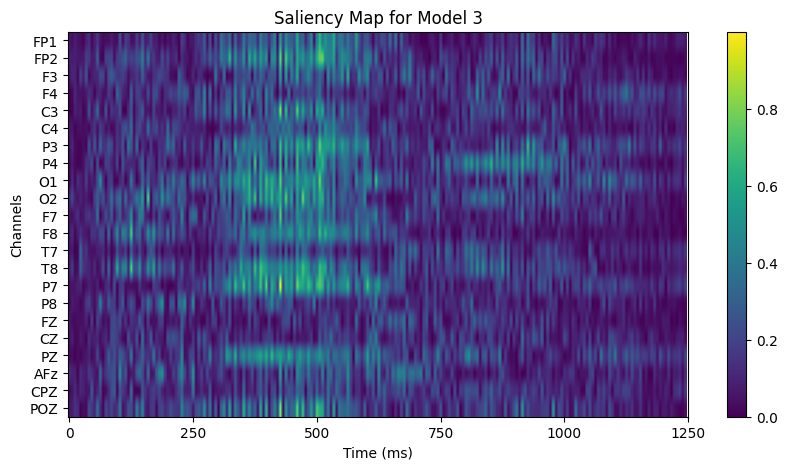

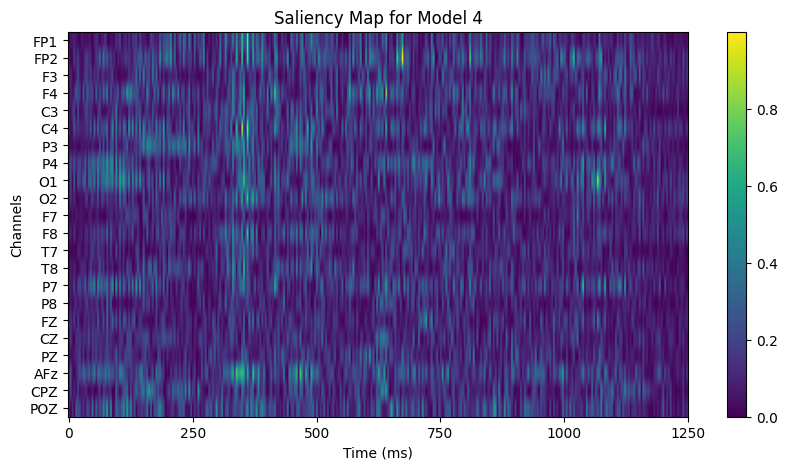

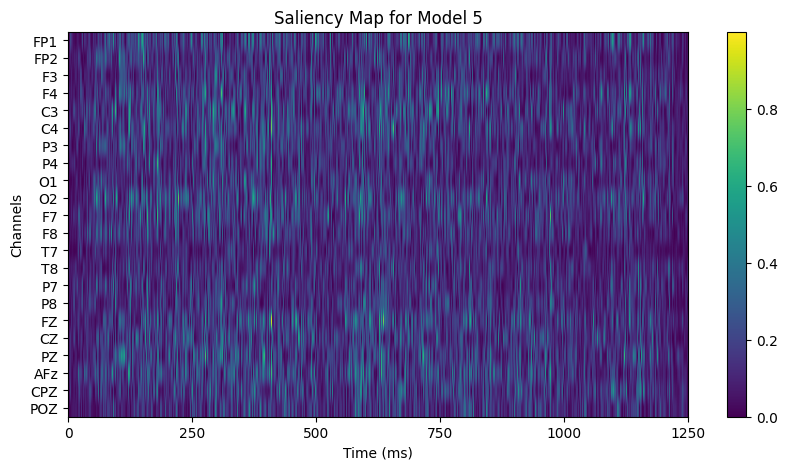

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tensorflow.keras import backend as K

# Channel mapping
channel_mapping = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

# Order channels by the second number
ordered_channels = sorted(channel_mapping.items(), key=lambda item: item[1])
channel_labels = ['FP2', 'F8', 'AFz', 'F4', 'F7', 'FP1', 'FZ', 'T7', 'F3', 'C3', 'P3', 'CZ', 'P7', 'O1', 'CPZ', 'PZ', 'C4', 'POZ', 'P4', 'T8', 'O2', 'P8']
ordered_channel_labels = [channel_labels[item[0]] for item in ordered_channels]

num_classess =3
chans = 22
models = []

models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 100,
               dropoutRate = 0.5, kernLength = 6, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 140,
               dropoutRate = 0.5, kernLength = 10, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 220,
               dropoutRate = 0.5, kernLength = 18, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 340,
               dropoutRate = 0.5, kernLength = 26, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))
models.append(EEGNet(nb_classes = num_classess, Chans = chans, Samples = 660,
               dropoutRate = 0.5, kernLength = 48, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout'))

# compile the model and set the optimizers
for model in models:
    model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
    print(model.count_params())

weights_paths = [
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod0.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod1.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod2.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod3.h5',
    '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod4.h5'
]

lims = [0, 100, 240, 460, 800, 1460]

# Generate and plot saliency maps for each model
for i, model in enumerate(models):
    # Define the score function to maximize the output for the true class
    true_classes = np.argmax(y_test)
    score = CategoricalScore(true_classes)
    
    # Create a Saliency object with the model and score function
    saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=False)
    
    # Generate saliency map
    X_test_slice = X_test[:, :, lims[i]:lims[i+1], :]
    saliency_maps = saliency(score, X_test_slice)
    
    # Plot the saliency map for the first sample
    plt.figure(figsize=(10, 5))
    plt.title(f'Saliency Map for Model {i+1}')
    plt.imshow(saliency_maps[0], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Time (ms)')
    plt.ylabel('Channels')
    
    # Set consistent x-ticks from 0 to 1250 ms
    num_ticks = 6
    time_ticks = np.linspace(0, 1250, num_ticks)
    sample_ticks = np.linspace(0, X_test_slice.shape[2], num_ticks)
    plt.xticks(sample_ticks, [f'{int(t)}' for t in time_ticks])
    
    # Set y-ticks based on ordered channels
    plt.yticks(np.arange(len(ordered_channels)), ordered_channel_labels)
    
    plt.show()

## Train merged model

### Compile model

In [13]:
from tensorflow.keras.layers import concatenate

# Load models with intermediate outputs
def load_intermediate_eegnet_model(filepath, nb_classes, Chans, Samples, trainable):
    model = EEGNet(nb_classes, Chans, Samples, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout', return_intermediate=True)
    model.load_weights(filepath, skip_mismatch=True, by_name=True)
    for layer in model.layers:
        layer.trainable = trainable
    return model

# Define input shapes
input_shape_filter1 = (22, 100, 1)
input_shape_filter2 = (22, 140, 1)
input_shape_filter3 = (22, 220, 1)
input_shape_filter4 = (22, 340, 1)
input_shape_filter5 = (22, 660, 1)

# Load individual models
inputs_filter1 = Input(shape=input_shape_filter1)
model_filter1 = load_intermediate_eegnet_model('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod'+str(0) +'.h5', 3, 22, 100, True)(inputs_filter1)

inputs_filter2 = Input(shape=input_shape_filter2)
model_filter2 = load_intermediate_eegnet_model('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod'+str(1) +'.h5', 3, 22, 140, True)(inputs_filter2)

inputs_filter3 = Input(shape=input_shape_filter3)
model_filter3 = load_intermediate_eegnet_model('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod'+str(2) +'.h5', 3, 22, 220, True)(inputs_filter3)

inputs_filter4 = Input(shape=input_shape_filter4)
model_filter4 = load_intermediate_eegnet_model('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod'+str(3) +'.h5', 3, 22, 340, True)(inputs_filter4)

inputs_filter5 = Input(shape=input_shape_filter5)
model_filter5 = load_intermediate_eegnet_model('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmod'+str(4) +'.h5', 3, 22, 660, True)(inputs_filter5)

# Merge models
merged = concatenate([model_filter1, model_filter2, model_filter3, model_filter4, model_filter5])

# Fully connected layer and output
fc = Dense(64, activation='relu')(merged)
dense = Dense(3)(fc)
output = Activation('softmax', name='softmax')(dense)
# Create final model
final_model = Model(inputs=[inputs_filter1, inputs_filter2, inputs_filter3, inputs_filter4, inputs_filter5], outputs=output)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print final model summary
final_model.summary()


2024-06-11 01:23:16.646975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 01:23:16.670967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 01:23:16.671013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 01:23:16.673589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-11 01:23:16.673628: I tensorflow/compile

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 22, 100, 1)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 22, 140, 1)]         0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 22, 220, 1)]         0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 22, 340, 1)]         0         []                            
                                                                                            

In [14]:
lims = [0,100,240,460,800,1460]
X_t = []
X_v = []
for mod in range(5):
    X_t.append(X_train[:,:,lims[mod]:lims[mod+1],:])
    X_v.append(X_val[:,:,lims[mod]:lims[mod+1],:])

In [15]:
checkpoint_path= '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmodall.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# Fit the model on the combined dataset
history = final_model.fit(
    X_t, 
    y_train,
    batch_size=16,
    epochs=1000,
    validation_data=(X_v, y_val),
    verbose=2,
    callbacks=checkpointer, 
    class_weight = class_weights)
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmodall.pkl'

# Open the file in write-binary mode and dump the variables
with open(filepath, 'wb') as f:
    pickle.dump({'fittedModel': history, 'model': final_model}, f)

Epoch 1/1000


2024-06-11 01:23:51.015929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-11 01:23:51.315860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-11 01:23:51.401936: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-11 01:23:51.788227: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-11 01:23:52.451396: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faaa5af8c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-11 01:23:52.451427: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPE


Epoch 1: val_loss improved from inf to 1.08547, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNet_5F/checkpointmodall.h5


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


236/236 - 11s - loss: 1.1184 - accuracy: 0.3561 - val_loss: 1.0855 - val_accuracy: 0.3964 - 11s/epoch - 47ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 1.08547 to 1.08234, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNet_5F/checkpointmodall.h5
236/236 - 5s - loss: 1.0885 - accuracy: 0.3895 - val_loss: 1.0823 - val_accuracy: 0.3975 - 5s/epoch - 20ms/step
Epoch 3/1000

Epoch 3: val_loss did not improve from 1.08234
236/236 - 4s - loss: 1.0576 - accuracy: 0.4285 - val_loss: 1.0916 - val_accuracy: 0.4277 - 4s/epoch - 19ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.08234 to 1.04674, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNet_5F/checkpointmodall.h5
236/236 - 5s - loss: 1.0313 - accuracy: 0.4645 - val_loss: 1.0467 - val_accuracy: 0.4557 - 5s/epoch - 20ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 1.04674
236/236 - 5s - loss: 1.0036 - accuracy: 0.4817 - val_loss: 1.0720 - val_accuracy: 0.4473 - 5s/epoch - 20ms/step
Epoch 6/1000

Epoch 6: v

### Assessment

#### Accuracy evaluation both methods

In [19]:
lims = [0,100,240,460,800,1460]
X_tsts = []
for mod in range(5):
    X_tsts.append(X_test[:,:,lims[mod]:lims[mod+1],:])

# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedmodall.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel = data['fittedModel']
model = data['model']

# load optimal weights
model.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpointmodall.h5')

probs       = model.predict(X_tsts)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

59/59 [==============================] - 1s 6ms/step
Classification accuracy: 0.632750 


#### Performance

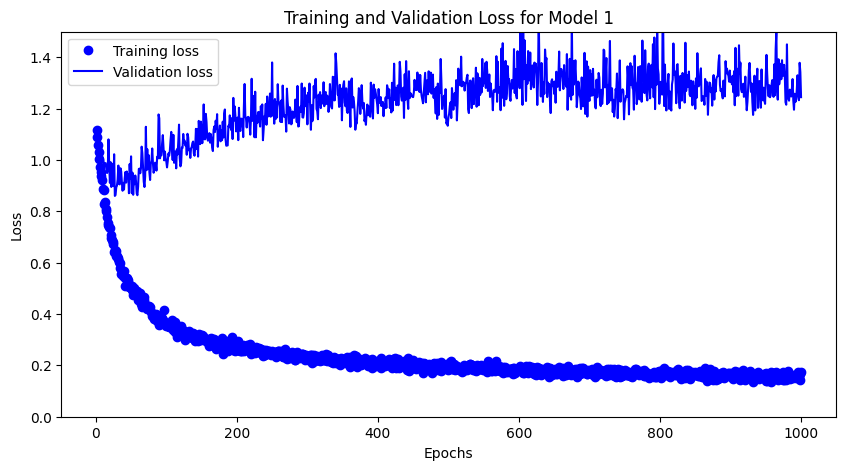

In [24]:
# Get loss and val_loss for the first model
loss1 = fittedModel.history['loss']
val_loss1 = fittedModel.history['val_loss']

# Determine the min and max values
y_min = 0
y_max = 1.5

# Plot for the first model
epochs1 = range(1, len(loss1) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and Validation Loss for Model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()



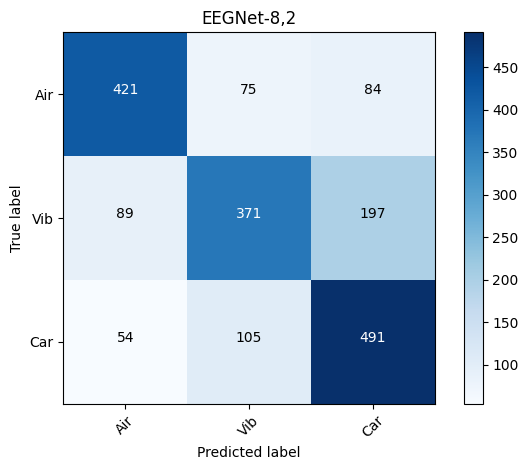

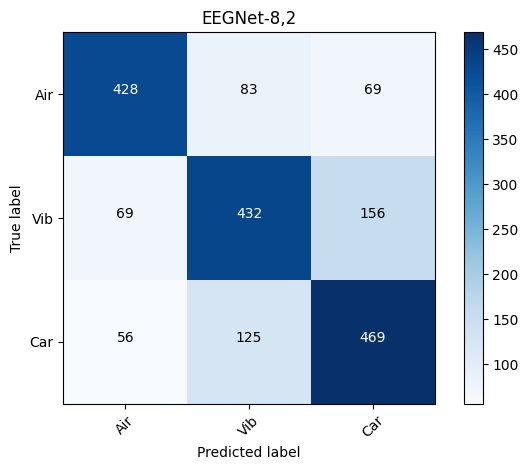

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization
import itertools  # Import itertools for product function

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds_hp)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

## EEGNET with Hyperparameters

### Define model and train using random search

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
import numpy as np
import scipy.io
import os
from PIL import Image
from keras_tuner.tuners import GridSearch, RandomSearch, Hyperband, BayesianOptimization

from keras.utils import get_custom_objects
from keras.optimizers import AdamW

In [13]:
def build_model(hp):
    get_custom_objects().update({'AdamW': AdamW})
    nb_classes = 3
    kernels, Chans, Samples = 1, 22, 500

    kernLength = hp.Int(f'kernLength', 32, 256, step = 32) # 32,
    F1 = hp.Int(f'F1', 6, 12, step = 2)
    D = hp.Int(f'D', 2, 8, step = 1)
    dropoutRate = hp.Float(f'dropoutRate', 0, 0.7, step = 0.2)
    F2 = hp.Int(f'F2', 16, 32, step = 4)
    norm_rate = 0.25
    opt = hp.Choice(f'optimizer', ['adam', 'AdamW'])
    dropoutType = hp.Choice('dropoutType',['Dropout', 'SpatialDropout2D'] )

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))
    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    #model.load_weights('/content/drive/MyDrive/NNcodes/Checkpoints/checkpoint_ACC65p_3class_1000epocs.keras', by_name=True, skip_mismatch=True)

    return model

### Train RandomSearch

In [14]:
tuner_rs = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=300,
    executions_per_trial=1,
    directory='/mnt/d/sharegit/MasterThesis_data/'+ model_name +'/logs/rs',
    project_name='EEGNetTunerC3Euc',
    overwrite=False
)

tuner_rs.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), class_weight = class_weights,
             callbacks=[keras.callbacks.TensorBoard('/mnt/d/sharegit/MasterThesis_data/'+ model_name +'/logs/rs/rs_logs')])

Trial 300 Complete [00h 00m 54s]
val_accuracy: 0.527292013168335

Best val_accuracy So Far: 0.5882353186607361
Total elapsed time: 14h 43m 49s


### Visualize Results using Tensorboard

In [15]:
%reload_ext tensorboard

In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
%tensorboard --logdir /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/logs/rs/rs_logs

Reusing TensorBoard on port 6006 (pid 156263), started 0:00:48 ago. (Use '!kill 156263' to kill it.)

## Train using hyperparameters

### Compile model

In [12]:
model = EEGNet(nb_classes = num_classess, Chans = chans, Samples = samples,
               dropoutRate = 0.2, kernLength = 64, F1 = 10, D = 8, F2 = 16,
               dropoutType = 'Dropout')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# count number of parameters in the model
model.count_params()

model.summary()

2024-06-10 15:26:48.070773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 500, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 22, 500, 10)       640       
                                                                 
 batch_normalization (Batch  (None, 22, 500, 10)       40        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 500, 80)        1760      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 500, 80)        320       
 chNormalization)                                                
                                                             

2024-06-10 15:26:48.131742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.131788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.135097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.135159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.135192: I tensorflow/compile

### Train model

In [13]:
# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5', verbose=1,   save_best_only=True)

# load optimal weights
#model.load_weights('checkpoint_ACC65p_3class.keras', by_name=True, skip_mismatch=True)
fittedModel = model.fit(X_train, y_train, batch_size = 16, epochs = 1000,
                        verbose = 2, validation_data=(X_val, y_val),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/1000


2024-06-10 15:26:49.365771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-10 15:26:49.483938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-10 15:26:49.625197: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-10 15:26:49.903466: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-10 15:26:50.326507: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f33b047f900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 15:26:50.326534: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compu


Epoch 1: val_loss improved from inf to 1.08303, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 4s - loss: 1.0896 - accuracy: 0.3702 - val_loss: 1.0830 - val_accuracy: 0.3906 - 4s/epoch - 17ms/step
Epoch 2/1000


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.08303 to 1.06149, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0639 - accuracy: 0.4187 - val_loss: 1.0615 - val_accuracy: 0.4155 - 2s/epoch - 7ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.06149 to 1.04018, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0440 - accuracy: 0.4494 - val_loss: 1.0402 - val_accuracy: 0.4584 - 2s/epoch - 7ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.04018 to 1.03183, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0129 - accuracy: 0.4828 - val_loss: 1.0318 - val_accuracy: 0.4780 - 2s/epoch - 7ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 1.03183 to 0.99561, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/

### Save model results

In [14]:
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

# Open the file in write-binary mode and dump the variables
with open(filepath, 'wb') as f:
    pickle.dump({'fittedModel': fittedModel, 'model': model}, f)
